## Learning best practices for model evaluation and hyperparameter tuning

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                 header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.shape

(569, 32)

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# Checking the working of the label encoder
le.transform(['B', 'M'])

array([0, 1])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

### Combining transformers and estimators in a pipeline 

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [10]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(random_state = 1))

In [11]:
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


### Using k-fold cross-validation to assess model performance 

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [13]:
kfold = StratifiedKFold(n_splits = 10,
                        random_state = 1).split(X_train, y_train)

In [14]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist: %s, Acc: %.3f' % (k + 1,
                                                   np.bincount(y_train[train]), score))

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist: [256 153], Acc: 0.891
Fold:  2, Class dist: [256 153], Acc: 0.978
Fold:  3, Class dist: [256 153], Acc: 0.978
Fold:  4, Class dist: [256 153], Acc: 0.913
Fold:  5, Class dist: [256 153], Acc: 0.935
Fold:  6, Class dist: [257 153], Acc: 0.978
Fold:  7, Class dist: [257 153], Acc: 0.933
Fold:  8, Class dist: [257 153], Acc: 0.956
Fold:  9, Class dist: [257 153], Acc: 0.978
Fold: 10, Class dist: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
scores = cross_val_score(estimator = pipe_lr,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)

In [17]:
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV accuracy: 0.950 +/- 0.029


### Debugging algorithms with learning and validation curves 

In [18]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [19]:
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty = 'l2', random_state = 1))

train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1, 1.0, 10),
                                                        cv = 10,
                                                        n_jobs = 1)

In [20]:
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

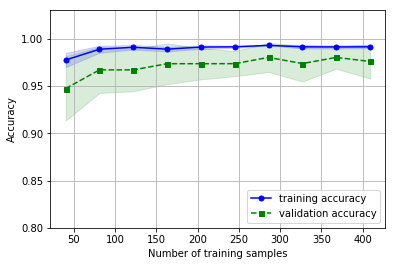

In [21]:
plt.plot(train_sizes, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(train_sizes, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5, label = 'validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.03])
plt.show()

### Addresssing overfitting and underfitting with validation curves 

In [22]:
from sklearn.learning_curve import validation_curve

In [23]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'logisticregression__C',
                                             param_range = param_range,
                                             cv = 10)

In [24]:
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

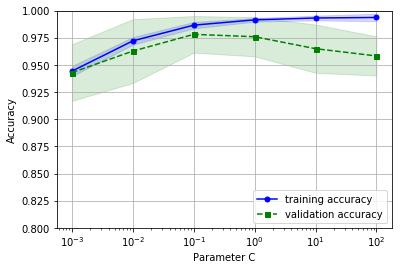

In [25]:
plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'training accuracy')
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5, label = 'validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.0])
plt.show()

### Fine tuning machine learning models via grid search

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [27]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1)

gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'svc__kernel': ['linear']}, {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'svc__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [28]:
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'svc__C': 0.1, 'svc__kernel': 'linear'}


In [29]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.965


### Algorithm selection with nested cross validation 

In [30]:
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2,
                  n_jobs = -1)

In [31]:
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)

In [32]:
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV Accuracy: 0.965 +/- 0.025


In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                  param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring = 'accuracy',
                  cv = 2)

In [35]:
scores = cross_val_score(gs,
                         X_train,
                         y_train,
                         scoring = 'accuracy',
                         cv = 5)

In [36]:
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV Accuracy: 0.921 +/- 0.029


### Different performance evaluation metrics 

#### Confusion Matrix 

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


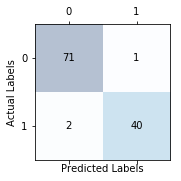

In [40]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j,
                y = i,
                s = confmat[i, j],
                va = 'center',
                ha = 'center')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

#### Precision and Recall of classification model 

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [42]:
print('Precision: %.3f' % precision_score(y_true = y_test, y_pred = y_pred))
print('Recall: %.3f' % recall_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.3f' % f1_score(y_true = y_test, y_pred = y_pred))

Precision: 0.976
Recall: 0.952
F1-Score: 0.964


In [43]:
from sklearn.metrics import make_scorer

In [46]:
scorer = make_scorer(f1_score, pos_label = 0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 10,
                  n_jobs = -1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9827986682076318
{'svc__C': 0.1, 'svc__kernel': 'linear'}


#### Plotting Receiver Operating Characteristics Curve 

In [47]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [48]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(penalty = 'l2', random_state = 1, C = 100.0))

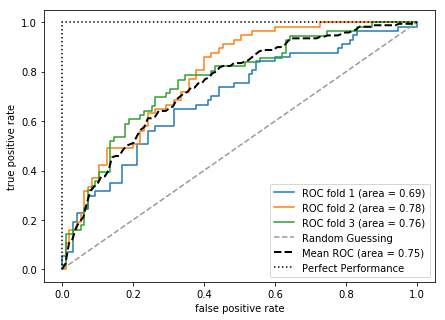

In [51]:
X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits = 3,
                          random_state = 1).split(X_train, y_train))

fig = plt.figure(figsize = (7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, threshold = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label = 1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label = 'ROC fold %d (area = %0.2f)' % (i + 1, roc_auc))
    
plt.plot([0, 1],
         [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'Random Guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         lw = 2, label = 'Mean ROC (area = %0.2f)' % mean_auc)

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle = ':',
         color = 'black',
         label = 'Perfect Performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.show()

In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

print('ROC AUC: %.3f' % roc_auc_score(y_true = y_test, y_score = y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true = y_test, y_pred = y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


#### Scoring metric for multiclass classification 

In [54]:
pre_scorer = make_scorer(score_func = precision_score,
                         pos_label = 1,
                         greater_is_better = True,
                         average = 'micro')

#### Dealing with class imbalance 

In [55]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [56]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [57]:
from sklearn.utils import resample

In [59]:
print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace = True,
                                    n_samples = X_imb[y_imb == 0].shape[0],
                                    random_state = 123)

print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


In [60]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [61]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0